<a href="https://colab.research.google.com/github/Rishabh672003/Learning-machine-learning/blob/main/jupyter-notebooks/sepsis_pred_pbl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting the Dataset from Kaggle

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

kaggle_creds_path = "/content/drive/MyDrive/Kaggle/kaggle.json"
! cp /content/drive/MyDrive/Kaggle/kaggle.json .

! pip install kaggle --quiet

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d salikhussaini49/prediction-of-sepsis

import zipfile
import os
import shutil
location = '/content/prediction-of-sepsis'
zip_ref = zipfile.ZipFile(location+'.zip', 'r')

if os.path.isdir(location):
    shutil.rmtree(location)
    os.mkdir(location)
else:
    os.mkdir(location)

zip_ref.extractall(location)
zip_ref.close()

# Unmount your Google Drive
drive.flush_and_unmount()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset URL: https://www.kaggle.com/datasets/salikhussaini49/prediction-of-sepsis
License(s): CC-BY-NC-SA-4.0
prediction-of-sepsis.zip: Skipping, found more recently modified local copy (use --force to force download)


# Importing the libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_absolute_error, mean_squared_error, confusion_matrix

# EDA

In [ ]:
df = pd.read_csv('/content/prediction-of-sepsis/Dataset.csv')
df.drop(["Unnamed: 0"], axis = 1, inplace = True)

In [ ]:
df.shape

(1552210, 43)

In [ ]:
df.sample(5)

,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_ID
834760,16,100.0,96.0,NaN,NaN,NaN,NaN,20.0,NaN,NaN,...,NaN,NaN,44.00,0,0.0,1.0,-20.86,17,0,112131
824249,47,102.0,99.0,36.9,105.0,74.00,63.0,18.0,NaN,NaN,...,NaN,NaN,53.00,1,1.0,0.0,-6.18,49,0,102370
682390,23,106.0,100.0,NaN,98.0,65.33,NaN,15.0,NaN,NaN,...,NaN,NaN,22.28,0,1.0,0.0,-0.03,24,0,17902
873985,26,94.0,96.0,38.1,134.0,75.00,52.0,20.0,NaN,NaN,...,NaN,NaN,70.00,1,0.0,1.0,-27.66,27,0,111051
49917,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,61.37,1,1.0,0.0,-0.03,7,0,17013


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1552210 entries, 0 to 1552209
Data columns (total 43 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Hour              1552210 non-null  int64  
 1   HR                1398811 non-null  float64
 2   O2Sat             1349474 non-null  float64
 3   Temp              525226 non-null   float64
 4   SBP               1325945 non-null  float64
 5   MAP               1358940 non-null  float64
 6   DBP               1065656 non-null  float64
 7   Resp              1313875 non-null  float64
 8   EtCO2             57636 non-null    float64
 9   BaseExcess        84145 non-null    float64
 10  HCO3              65028 non-null    float64
 11  FiO2              129365 non-null   float64
 12  pH                107573 non-null   float64
 13  PaCO2             86301 non-null    float64
 14  SaO2              53561 non-null    float64
 15  AST               25183 non-null    float64
 16  

In [ ]:
# basically halfs the storage of dataset
for col in df.select_dtypes(include=['float64']).columns:
  df[col] = df[col].astype('float32')
for col in df.select_dtypes(include=['int64']).columns:
  df[col] = df[col].astype('int32')

In [ ]:
print(f"Memory footprint of df: {round(df.memory_usage(deep=True).sum() / (1024 * 1024), 2)} MB")


Memory footprint of df: 254.61 MB


In [ ]:
(df.isnull().sum() / df.shape[0] * 100).sort_values(ascending=False)

,0
Bilirubin_direct,99.807371
Fibrinogen,99.340167
TroponinI,99.047745
Bilirubin_total,98.509158
Alkalinephos,98.393194
AST,98.377604
Lactate,97.329872
PTT,97.055875
SaO2,96.549372
EtCO2,96.286843


In [ ]:
df["SepsisLabel"].value_counts()

,count
SepsisLabel,
0,1524294
1,27916


In [ ]:
def corr_matrix(df):
  corr = df.corr()
  mask = np.triu(np.ones_like(corr, dtype=bool))
  f, ax = plt.subplots(figsize=(40,40))
  cmap = sns.diverging_palette(220, 10, as_cmap=True)
  sns.heatmap(corr, mask=mask, cmap="Paired", vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
!pip install ydata-profiling --quiet

from ydata_profiling import ProfileReport

profile = ProfileReport(df, title="Pandas Profiling Report")

In [ ]:
profile.to_file("sepsis_prediction.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Preprocessing

In [ ]:
columns_drop={'SBP','DBP','EtCO2','BaseExcess', 'HCO3','pH','PaCO2','Alkalinephos', 'Calcium','Magnesium',
'Phosphate','Potassium','PTT','Fibrinogen','Unit1','Unit2'}
df = df.assign(Unit=df['Unit1'] + df['Unit2'])
df_train_mod = df.drop(columns=columns_drop)
df_train_mod.columns

Index(['Hour', 'HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'FiO2', 'SaO2', 'AST',
       'BUN', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose',
       'Lactate', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'WBC',
       'Platelets', 'Age', 'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel',
       'Patient_ID', 'Unit'],
      dtype='object')

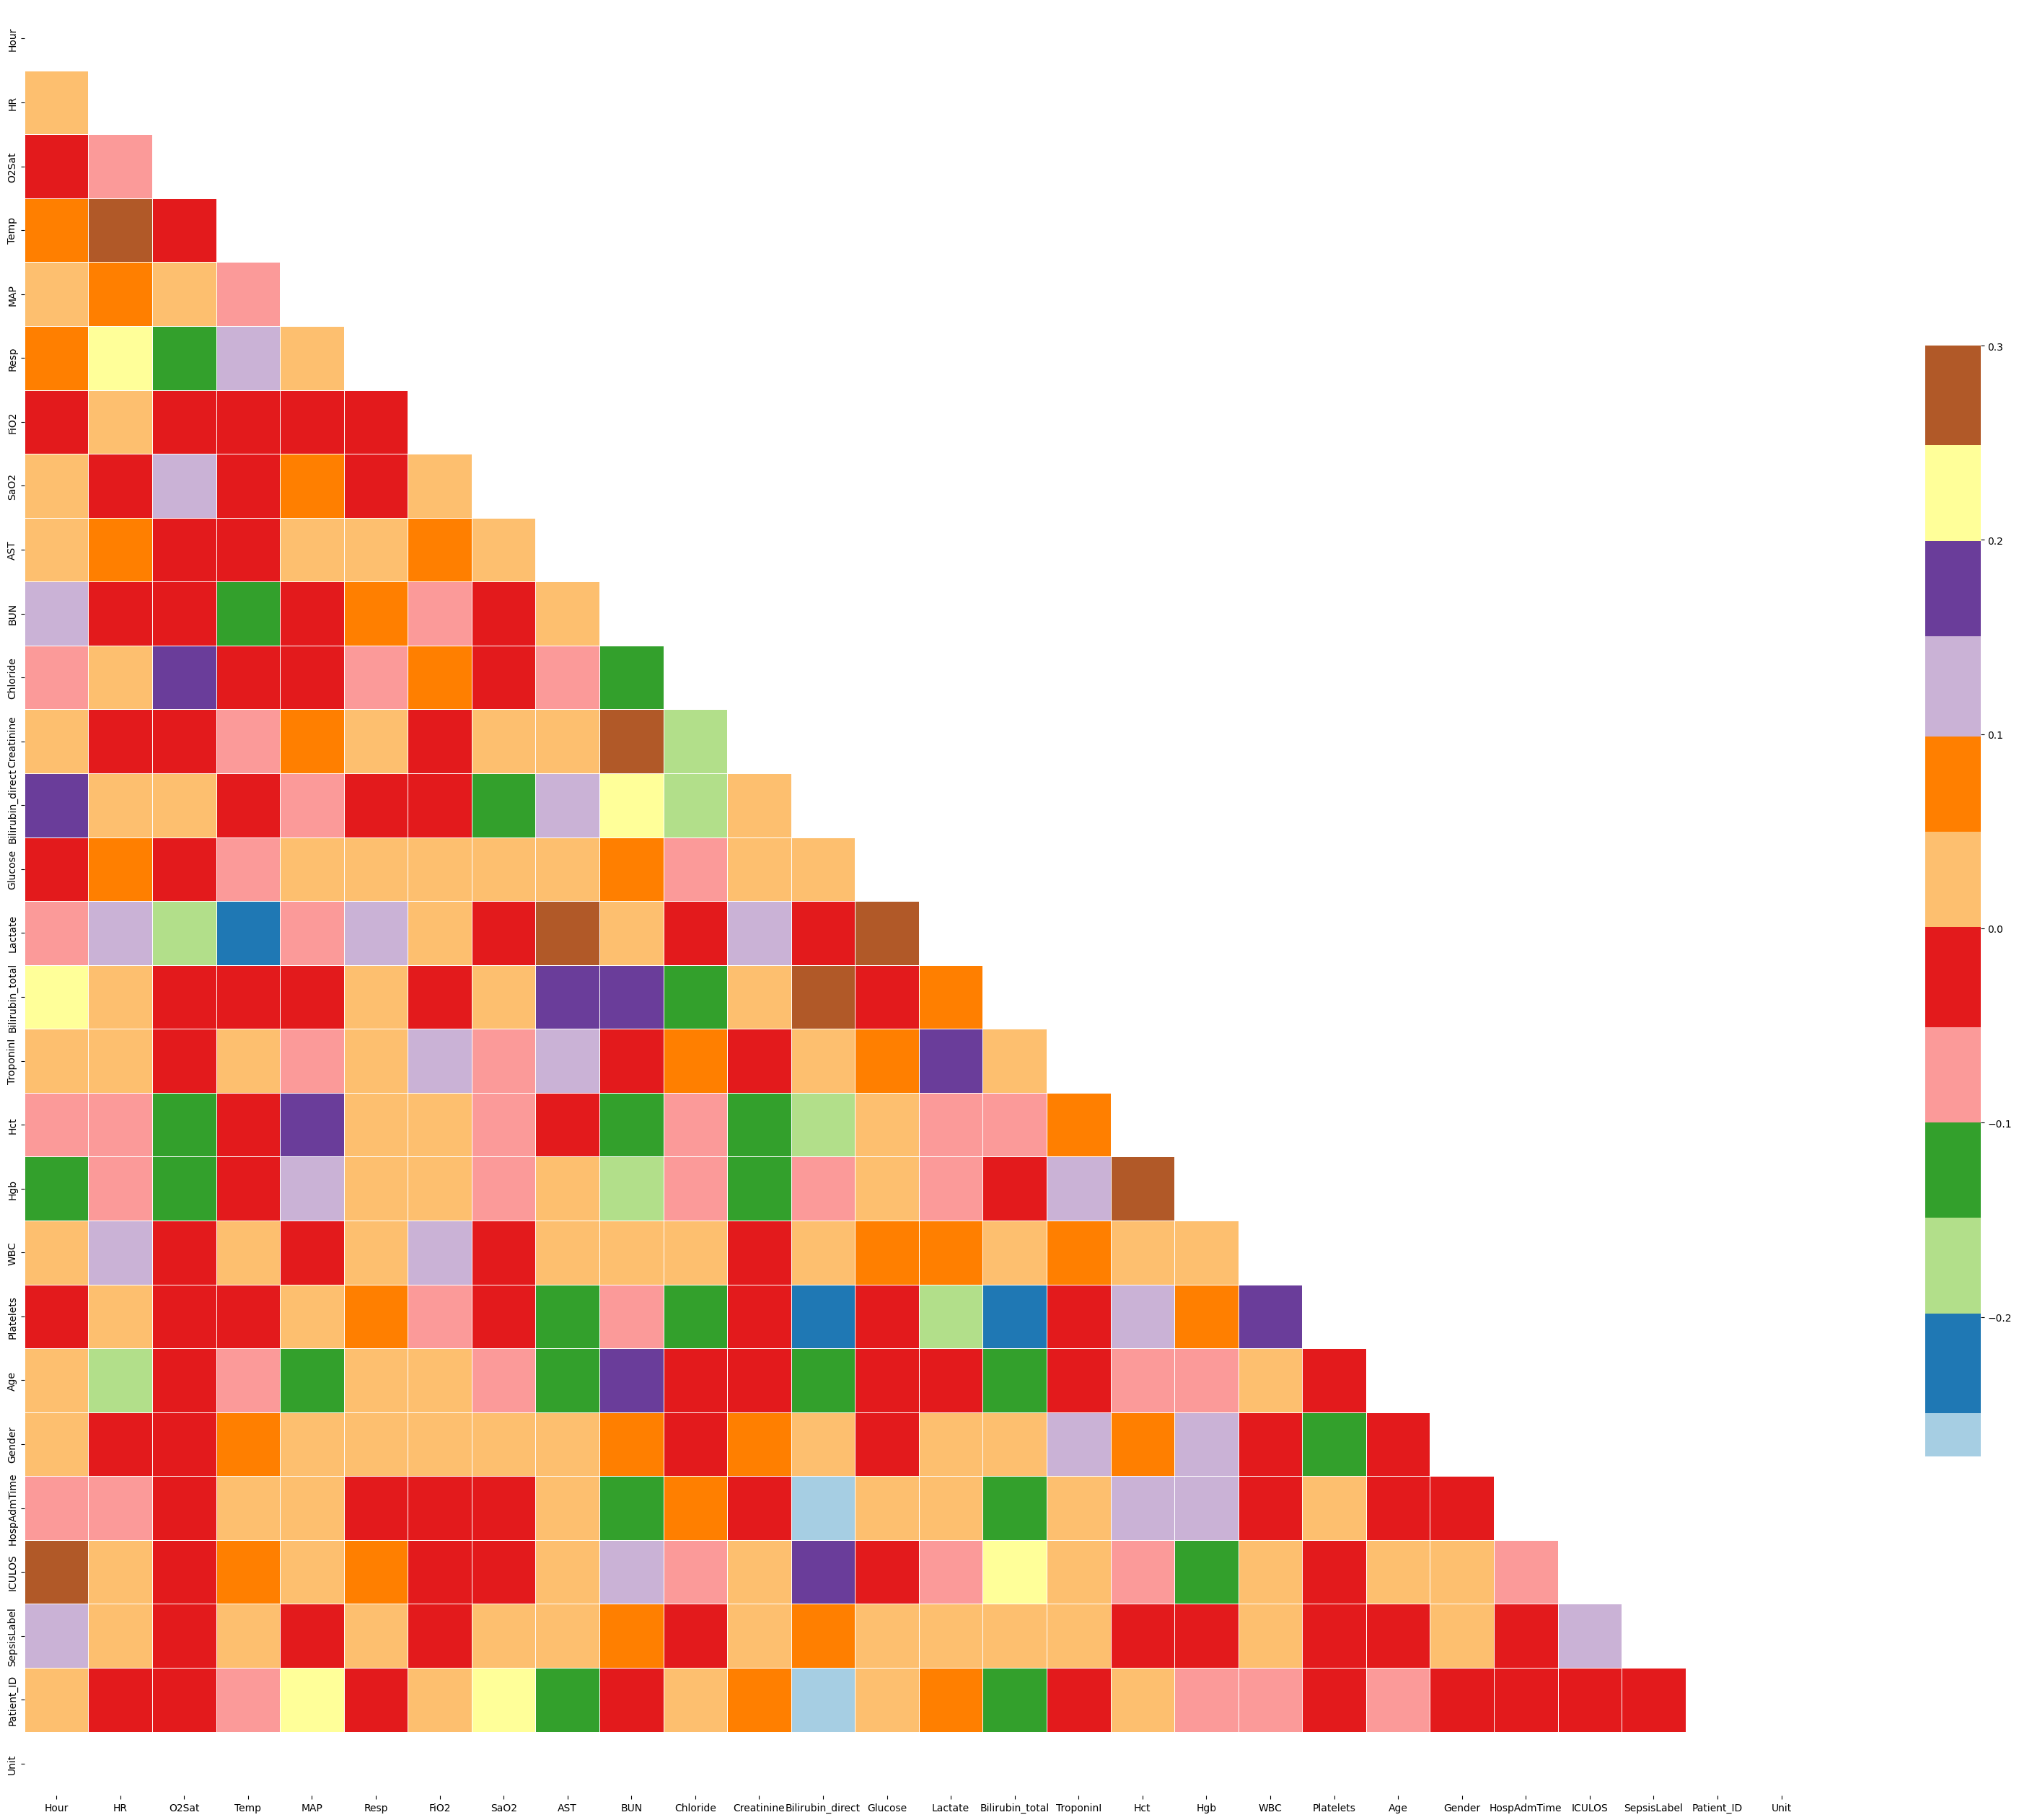

In [ ]:
corr_matrix(df_train_mod)

In [ ]:
df_train_impute = df_train_mod.copy()
columns_impute = list(df_train_impute.columns)

In [ ]:
grouped_by_patient = df_train_impute.groupby('Patient_ID')
df_train_impute = grouped_by_patient.apply(lambda x: x.bfill().ffill())

<ipython-input-94-354395450214>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_impute = grouped_by_patient.apply(lambda x: x.bfill().ffill())


In [ ]:
df_train_impute.head()

Hour     HR  O2Sat       Temp        MAP  Resp  FiO2  SaO2  \
Patient_ID                                                                      
1          132940     0   97.0   95.0  36.110001  75.330002  19.0  0.28  88.0   
           132941     1   97.0   95.0  36.110001  75.330002  19.0  0.28  88.0   
           132942     2   89.0   99.0  36.110001  86.000000  22.0  0.28  88.0   
           132943     3   90.0   95.0  36.110001  91.330002  30.0  0.28  88.0   
           132944     4  103.0   88.5  36.110001  91.330002  24.5  0.28  88.0   

                    AST   BUN  ...   Hgb  WBC  Platelets        Age  Gender  \
Patient_ID                     ...                                            
1          132940  16.0  14.0  ...  12.5  5.7      317.0  83.139999       0   
           132941  16.0  14.0  ...  12.5  5.7      317.0  83.139999       0   
           132942  16.0  14.0  ...  12.5  5.7      317.0  83.139999       0   
           132943  16.0  14.0  ...  12.5  5.7      317.0  83.139999       0   
           132944  16.0  14.0  ...  12.5  5.7      317.0  83.139999       0   

                   HospAdmTime  ICULOS  SepsisLabel  Patient_ID  Unit  
Patient_ID                                                             
1          132940        -0.03       1            0           1   NaN  
           132941        -0.03       2            0           1   NaN  
           132942        -0.03       3            0           1   NaN  
           132943        -0.03       4            0           1   NaN  
           132944        -0.03       5            0           1   NaN  

[5 rows x 28 columns]

In [ ]:
null_values = df_train_impute.isnull().mean()*100
null_values = null_values.sort_values(ascending=False)
null_values

,0
Bilirubin_direct,93.266633
TroponinI,81.905412
Lactate,63.533607
SaO2,62.980589
Bilirubin_total,59.799447
AST,59.567520
FiO2,50.224390
Chloride,44.905329
Unit,39.425078
WBC,4.227456


In [ ]:
null_col = ['TroponinI', 'Bilirubin_direct', 'AST', 'Bilirubin_total', 'Lactate', 'SaO2', 'FiO2',
            'Unit', 'Patient_ID']
df_train_impute = df_train_impute.drop(columns=null_col)
df_train_impute.columns

Index(['Hour', 'HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets', 'Age',
       'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

In [ ]:
one_hot = pd.get_dummies(df_train_impute['Gender'], prefix='gender')
df_train_impute = df_train_impute.join(one_hot)
df_train_impute = df_train_impute.drop('Gender', axis=1)

In [ ]:
df_train_impute.head(100)

Hour     HR  O2Sat       Temp        MAP  Resp   BUN  \
Patient_ID                                                                
1          132940     0   97.0   95.0  36.110001  75.330002  19.0  14.0   
           132941     1   97.0   95.0  36.110001  75.330002  19.0  14.0   
           132942     2   89.0   99.0  36.110001  86.000000  22.0  14.0   
           132943     3   90.0   95.0  36.110001  91.330002  30.0  14.0   
           132944     4  103.0   88.5  36.110001  91.330002  24.5  14.0   
...                 ...    ...    ...        ...        ...   ...   ...   
3          724306    18   72.5   94.5  37.060001  85.500000  29.0  25.0   
           724307    19   72.0   96.0  37.500000  84.000000  20.0  25.0   
           724308    20   75.0   97.0  37.500000  86.000000  22.0  25.0   
           724309    21   81.5   95.5  37.500000  93.500000  20.5  25.0   
           724310    22   80.0   95.0  37.500000  86.000000  26.0  25.0   

                   Chloride  Creatinine  Glucose        Hct   Hgb  WBC  \
Patient_ID                                                               
1          132940      85.0         0.7    193.0  37.200001  12.5  5.7   
           132941      85.0         0.7    193.0  37.200001  12.5  5.7   
           132942      85.0         0.7    193.0  37.200001  12.5  5.7   
           132943      85.0         0.7    193.0  37.200001  12.5  5.7   
           132944      85.0         0.7    193.0  37.200001  12.5  5.7   
...                     ...         ...      ...        ...   ...  ...   
3          724306     100.0         0.8    130.0  29.400000  11.0  8.7   
           724307     100.0         0.8    130.0  29.400000  11.0  8.7   
           724308     100.0         0.8    130.0  29.400000  11.0  8.7   
           724309     100.0         0.8    130.0  29.400000  11.0  8.7   
           724310     100.0         0.8    130.0  29.400000  11.0  8.7   

                   Platelets        Age  HospAdmTime  ICULOS  SepsisLabel  \
Patient_ID                                                                  
1          132940      317.0  83.139999    -0.030000       1            0   
           132941      317.0  83.139999    -0.030000       2            0   
           132942      317.0  83.139999    -0.030000       3            0   
           132943      317.0  83.139999    -0.030000       4            0   
           132944      317.0  83.139999    -0.030000       5            0   
...                      ...        ...          ...     ...          ...   
3          724306      486.0  45.820000 -1195.709961      19            0   
           724307      486.0  45.820000 -1195.709961      20            0   
           724308      486.0  45.820000 -1195.709961      21            0   
           724309      486.0  45.820000 -1195.709961      22            0   
           724310      486.0  45.820000 -1195.709961      23            0   

                   gender_0  gender_1  
Patient_ID                             
1          132940      True     False  
           132941      True     False  
           132942      True     False  
           132943      True     False  
           132944      True     False  
...                     ...       ...  
3          724306      True     False  
           724307      True     False  
           724308      True     False  
           724309      True     False  
           724310      True     False  

[100 rows x 20 columns]

In [ ]:
columns_normalized = ['MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
for i in columns_normalized:
  df_train_impute[i] = np.log(df_train_impute[i]+1)

In [ ]:
df_train_impute.head()

Hour     HR  O2Sat       Temp       MAP  Resp      BUN  \
Patient_ID                                                                  
1          132940     0   97.0   95.0  36.110001  4.335066  19.0  2.70805   
           132941     1   97.0   95.0  36.110001  4.335066  19.0  2.70805   
           132942     2   89.0   99.0  36.110001  4.465908  22.0  2.70805   
           132943     3   90.0   95.0  36.110001  4.525369  30.0  2.70805   
           132944     4  103.0   88.5  36.110001  4.525369  24.5  2.70805   

                   Chloride  Creatinine   Glucose        Hct   Hgb       WBC  \
Patient_ID                                                                     
1          132940      85.0    0.530628  5.267858  37.200001  12.5  1.902107   
           132941      85.0    0.530628  5.267858  37.200001  12.5  1.902107   
           132942      85.0    0.530628  5.267858  37.200001  12.5  1.902107   
           132943      85.0    0.530628  5.267858  37.200001  12.5  1.902107   
           132944      85.0    0.530628  5.267858  37.200001  12.5  1.902107   

                   Platelets        Age  HospAdmTime  ICULOS  SepsisLabel  \
Patient_ID                                                                  
1          132940   5.762052  83.139999        -0.03       1            0   
           132941   5.762052  83.139999        -0.03       2            0   
           132942   5.762052  83.139999        -0.03       3            0   
           132943   5.762052  83.139999        -0.03       4            0   
           132944   5.762052  83.139999        -0.03       5            0   

                   gender_0  gender_1  
Patient_ID                             
1          132940      True     False  
           132941      True     False  
           132942      True     False  
           132943      True     False  
           132944      True     False

In [ ]:
scaler = StandardScaler()
df_train_impute[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']] = scaler.fit_transform(df_train_impute[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']])
df_train_impute.head()

Hour        HR     O2Sat      Temp       MAP      Resp  \
Patient_ID                                                                  
1          132940     0  0.722826 -0.687496 -1.039045 -0.388131  0.067226   
           132941     1  0.722826 -0.687496 -1.039045 -0.388131  0.067226   
           132942     2  0.262995  0.586728 -1.039045  0.294357  0.648747   
           132943     3  0.320474 -0.687496 -1.039045  0.604513  2.199469   
           132944     4  1.067700 -2.758111 -1.039045  0.604513  1.133347   

                        BUN  Chloride  Creatinine   Glucose       Hct  \
Patient_ID                                                              
1          132940 -0.372837 -3.711766   -0.591566  1.441964  1.004213   
           132941 -0.372837 -3.711766   -0.591566  1.441964  1.004213   
           132942 -0.372837 -3.711766   -0.591566  1.441964  1.004213   
           132943 -0.372837 -3.711766   -0.591566  1.441964  1.004213   
           132944 -0.372837 -3.711766   -0.591566  1.441964  1.004213   

                        Hgb       WBC  Platelets        Age  HospAdmTime  \
Patient_ID                                                                 
1          132940  1.001309 -1.150328   1.100279  83.139999        -0.03   
           132941  1.001309 -1.150328   1.100279  83.139999        -0.03   
           132942  1.001309 -1.150328   1.100279  83.139999        -0.03   
           132943  1.001309 -1.150328   1.100279  83.139999        -0.03   
           132944  1.001309 -1.150328   1.100279  83.139999        -0.03   

                   ICULOS  SepsisLabel  gender_0  gender_1  
Patient_ID                                                  
1          132940       1            0      True     False  
           132941       2            0      True     False  
           132942       3            0      True     False  
           132943       4            0      True     False  
           132944       5            0      True     False

In [ ]:
df_train_impute = df_train_impute.dropna()

In [ ]:
null_values = df_train_impute.isnull().mean()*100
null_values

,0
Hour,0.0
HR,0.0
O2Sat,0.0
Temp,0.0
MAP,0.0
Resp,0.0
BUN,0.0
Chloride,0.0
Creatinine,0.0
Glucose,0.0


In [ ]:
# checking the distribution of data points between the two classes

majority_class = df_train_impute[df_train_impute['SepsisLabel'] == 0]
minority_class = df_train_impute[df_train_impute['SepsisLabel'] == 1]
print('number of sepsis label 1 is {}'.format(len(minority_class)))
print('while number of sepsis label 0 is {}'.format(len(majority_class)))

number of sepsis label 1 is 17243
while number of sepsis label 0 is 823283


In [ ]:
# Undersampling

majority_class_subset = majority_class.sample(n=2*len(minority_class))
df_train_impute = pd.concat([majority_class_subset, minority_class])

In [ ]:
# train test split for the imputed output
X = df_train_impute.drop('SepsisLabel', axis=1)
y = df_train_impute['SepsisLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
X.shape

(51729, 19)

# Training the models

In [ ]:
def evaluate_model(y_true,y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  print("Accuracy:", accuracy)
  precision = precision_score(y_true, y_pred)
  print("Precision:", precision)
  recall = recall_score(y_true, y_pred)
  print("Recall:", recall)
  f1 = f1_score(y_true, y_pred)
  print("F1 Score:", f1)
  auc = roc_auc_score(y_true, y_pred)
  print("AUC-ROC:", auc)
  mae = mean_absolute_error(y_true, y_pred)
  print("Mean Absolute Error:", mae)
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  print("Root Mean Squared Error:", rmse)
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, fmt='d')
  plt.show()

In [ ]:
model = RandomForestClassifier(n_estimators=300, random_state=0)
model.fit(X_train, y_train)
rcf_predictions = model.predict(X_test)

Accuracy: 0.9612410593466074
Precision: 0.9232289020604008
Recall: 0.9620588235294117
F1 Score: 0.9422439867492438
AUC-ROC: 0.9614497975982791
Mean Absolute Error: 0.038758940653392616
Root Mean Squared Error: 0.19687290482286438


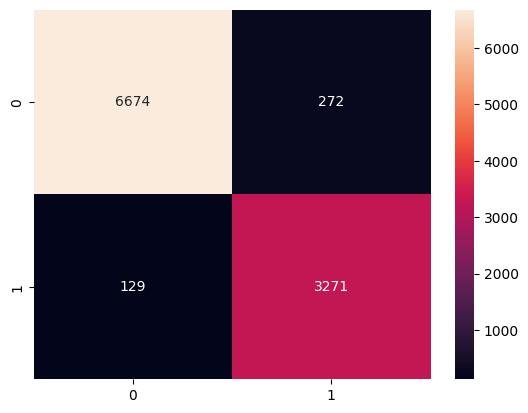

In [ ]:
evaluate_model(y_test,rcf_predictions)

Accuracy: 0.7593272762420259
Precision: 0.7252475247524752
Recall: 0.4308823529411765
F1 Score: 0.540590405904059
AUC-ROC: 0.6754901255060043
Mean Absolute Error: 0.2406727237579741
Root Mean Squared Error: 0.49058406390543724


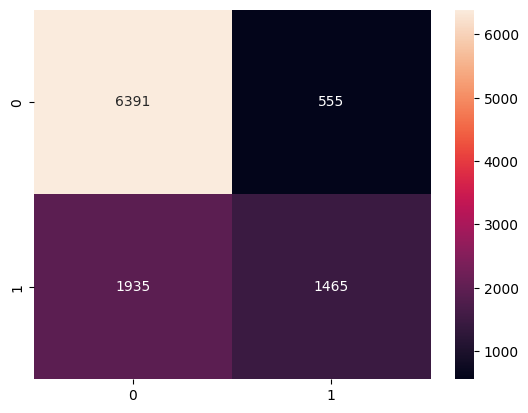

In [ ]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
nbc_predictions = model.predict(X_test)
evaluate_model(y_test,nbc_predictions)

Accuracy: 0.8251498163541465
Precision: 0.7749740753543035
Recall: 0.6594117647058824
F1 Score: 0.7125377403464167
AUC-ROC: 0.7828443793296184
Mean Absolute Error: 0.17485018364585347
Root Mean Squared Error: 0.4181509101339533


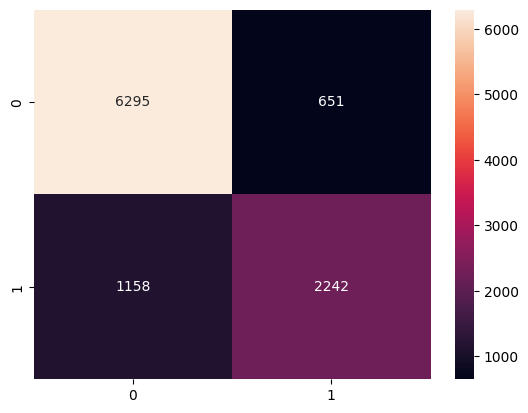

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# model = KNeighborsClassifier(n_neighbors=8)
# model = KNeighborsClassifier(n_neighbors=5)
model = KNeighborsClassifier(n_neighbors=10)
model.fit(X_train, y_train)
knn_predictions = model.predict(X_test)
evaluate_model(y_test,knn_predictions)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.7544944906243959
Precision: 0.7432126696832579
Recall: 0.3864705882352941
F1 Score: 0.5085139318885449
AUC-ROC: 0.6605546145898613
Mean Absolute Error: 0.2455055093756041
Root Mean Squared Error: 0.4954851252818838


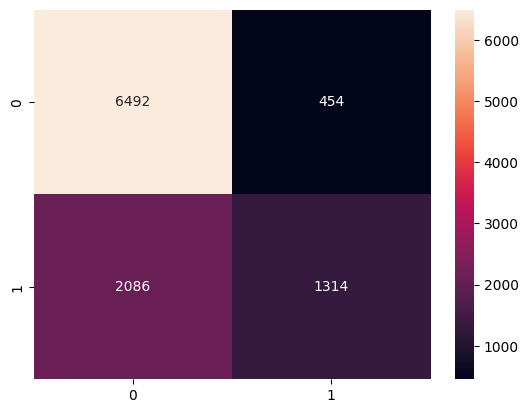

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
lr_predictions = model.predict(X_test)
evaluate_model(y_test,lr_predictions)

### Therefore we see the Random forest performs the best